<a href="https://colab.research.google.com/github/tuancompa2610/Predict-Mexico-House-Price/blob/main/Predict_Mexico_House_Price_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Preparation

In [26]:
# Import libraries
!pip install category_encoders

from glob import glob
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("/content/drive/MyDrive/mexico-house/mexico-city-real-estate-1.csv", index_col = 0)
df.head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
1,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851900,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
2,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
3,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
4,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481480,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
5,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


# 2. Feature Engineering

In [4]:
# To be more specific I will only focus on apartments in "Distrito Federal
# which cost less than $100000
mask_apt = df["place_with_parent_names"].str.contains("Distrito Federal")
mask_price = df['price_aprox_usd'] < 100000
mask_prt = df['property_type'] == "apartment"
df = df[mask_apt & mask_price & mask_prt]
df.head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
3,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.67000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
12,sell,apartment,|Benito Juárez|Distrito Federal|México|,"23.634501,-102.552788",1784569.0,MXN,1768425.20,94022.66,NaN,57.0,NaN,31308.22807,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/pdji_ven...
15,sell,apartment,|Benito Juárez|Distrito Federal|México|,"19.36269,-99.150565",1260000.0,MXN,1248601.52,66384.96,NaN,103.0,NaN,12233.00971,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/onph_ven...
21,sell,apartment,|Iztacalco|Distrito Federal|México|,"19.4024128,-99.0953907",1345000.0,MXN,1333148.73,70880.12,56.0,56.0,1265.716429,24017.85714,NaN,NaN,NaN,http://iztacalco.properati.com.mx/r6gm_venta_d...
22,sell,apartment,|Benito Juárez|Distrito Federal|México|,"19.35782,-99.149406",1295000.0,MXN,1283284.95,68228.99,NaN,80.0,NaN,16187.50000,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/qvop_ven...


In [5]:
# Split "lat-lon" into 2 separate features "lat" and "lon"
df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand = True).astype(float)
df.drop(columns = ["lat-lon"], inplace = True)
df.head()

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
3,sell,apartment,|Tlalpan|Distrito Federal|México|,926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.67000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...,19.279771,-99.234597
12,sell,apartment,|Benito Juárez|Distrito Federal|México|,1784569.0,MXN,1768425.20,94022.66,NaN,57.0,NaN,31308.22807,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/pdji_ven...,23.634501,-102.552788
15,sell,apartment,|Benito Juárez|Distrito Federal|México|,1260000.0,MXN,1248601.52,66384.96,NaN,103.0,NaN,12233.00971,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/onph_ven...,19.362690,-99.150565
21,sell,apartment,|Iztacalco|Distrito Federal|México|,1345000.0,MXN,1333148.73,70880.12,56.0,56.0,1265.716429,24017.85714,NaN,NaN,NaN,http://iztacalco.properati.com.mx/r6gm_venta_d...,19.402413,-99.095391
22,sell,apartment,|Benito Juárez|Distrito Federal|México|,1295000.0,MXN,1283284.95,68228.99,NaN,80.0,NaN,16187.50000,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/qvop_ven...,19.357820,-99.149406


In [6]:
# Create new feature "borough" to replace "place_with_parent_names"
df["borough"] = df["place_with_parent_names"].str.split("|", expand = True)[1]
df.drop(columns = ["place_with_parent_names"], inplace =True)
df.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,borough
3,sell,apartment,926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.67000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...,19.279771,-99.234597,Tlalpan
12,sell,apartment,1784569.0,MXN,1768425.20,94022.66,NaN,57.0,NaN,31308.22807,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/pdji_ven...,23.634501,-102.552788,Benito Juárez
15,sell,apartment,1260000.0,MXN,1248601.52,66384.96,NaN,103.0,NaN,12233.00971,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/onph_ven...,19.362690,-99.150565,Benito Juárez
21,sell,apartment,1345000.0,MXN,1333148.73,70880.12,56.0,56.0,1265.716429,24017.85714,NaN,NaN,NaN,http://iztacalco.properati.com.mx/r6gm_venta_d...,19.402413,-99.095391,Iztacalco
22,sell,apartment,1295000.0,MXN,1283284.95,68228.99,NaN,80.0,NaN,16187.50000,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/qvop_ven...,19.357820,-99.149406,Benito Juárez


### Drop Nan columns

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1405 entries, 3 to 4623
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1405 non-null   object 
 1   property_type               1405 non-null   object 
 2   price                       1405 non-null   float64
 3   currency                    1405 non-null   object 
 4   price_aprox_local_currency  1405 non-null   float64
 5   price_aprox_usd             1405 non-null   float64
 6   surface_total_in_m2         185 non-null    float64
 7   surface_covered_in_m2       1366 non-null   float64
 8   price_usd_per_m2            128 non-null    float64
 9   price_per_m2                1352 non-null   float64
 10  floor                       0 non-null      float64
 11  rooms                       33 non-null     float64
 12  expenses                    1 non-null      float64
 13  properati_url               1405 

In [8]:
df.drop(columns = ["floor", "expenses", "rooms"], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1405 entries, 3 to 4623
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1405 non-null   object 
 1   property_type               1405 non-null   object 
 2   price                       1405 non-null   float64
 3   currency                    1405 non-null   object 
 4   price_aprox_local_currency  1405 non-null   float64
 5   price_aprox_usd             1405 non-null   float64
 6   surface_total_in_m2         185 non-null    float64
 7   surface_covered_in_m2       1366 non-null   float64
 8   price_usd_per_m2            128 non-null    float64
 9   price_per_m2                1352 non-null   float64
 10  properati_url               1405 non-null   object 
 11  lat                         1318 non-null   float64
 12  lon                         1318 non-null   float64
 13  borough                     1405 

As you can see there are still a few features that has NaN value. However don't worry about it I have handle it later by using a technique call Imputation.

### Handle Low-Cardanality and High-Cardanality Feature

In [9]:
for i in df.columns:
  print(f"The number of unique values of feature {i}: {df[i].nunique()}")

The number of unique values of feature operation: 1
The number of unique values of feature property_type: 1
The number of unique values of feature price: 753
The number of unique values of feature currency: 2
The number of unique values of feature price_aprox_local_currency: 862
The number of unique values of feature price_aprox_usd: 862
The number of unique values of feature surface_total_in_m2: 60
The number of unique values of feature surface_covered_in_m2: 126
The number of unique values of feature price_usd_per_m2: 124
The number of unique values of feature price_per_m2: 1084
The number of unique values of feature properati_url: 1405
The number of unique values of feature lat: 828
The number of unique values of feature lon: 807
The number of unique values of feature borough: 15


From the experiment above It is effortless to realize that "operation" and "property_type", "currency" has only 1 and 2 values So these features are Low-Cardanality Features of the dataset.

On the other hand, "properati_url" has 1405 values which is excalty equal to the number of row. So "properati_url" will be High-Cardanality Feature.

In [10]:
df.drop(columns = ["operation", "property_type", "currency", "properati_url"], 
        inplace = True)
df.head()

,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,lat,lon,borough
3,926667.0,918284.00,48822.82,NaN,100.0,NaN,9266.67000,19.279771,-99.234597,Tlalpan
12,1784569.0,1768425.20,94022.66,NaN,57.0,NaN,31308.22807,23.634501,-102.552788,Benito Juárez
15,1260000.0,1248601.52,66384.96,NaN,103.0,NaN,12233.00971,19.362690,-99.150565,Benito Juárez
21,1345000.0,1333148.73,70880.12,56.0,56.0,1265.716429,24017.85714,19.402413,-99.095391,Iztacalco
22,1295000.0,1283284.95,68228.99,NaN,80.0,NaN,16187.50000,19.357820,-99.149406,Benito Juárez


### Leakage Feature

Since our purpose is to predict the price of house in Mexico so our target will be "price_aprox_usd" so every feature relate to money will have a strong correlation with the target feature so I will drop those columns express price of house in the DataFrame

Those columns are "price", "price_aprox_local_currency", "price_per_m2", "price_usd_per_m2"

In [11]:
df.drop(columns = ["price", "price_aprox_local_currency", "price_per_m2", "price_usd_per_m2"], 
        inplace = True)
df.head()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,lat,lon,borough
3,48822.82,NaN,100.0,19.279771,-99.234597,Tlalpan
12,94022.66,NaN,57.0,23.634501,-102.552788,Benito Juárez
15,66384.96,NaN,103.0,19.362690,-99.150565,Benito Juárez
21,70880.12,56.0,56.0,19.402413,-99.095391,Iztacalco
22,68228.99,NaN,80.0,19.357820,-99.149406,Benito Juárez


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1405 entries, 3 to 4623
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        1405 non-null   float64
 1   surface_total_in_m2    185 non-null    float64
 2   surface_covered_in_m2  1366 non-null   float64
 3   lat                    1318 non-null   float64
 4   lon                    1318 non-null   float64
 5   borough                1405 non-null   object 
dtypes: float64(5), object(1)
memory usage: 76.8+ KB


Next, we need to keep an eye out for is multicollinearity, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap.

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


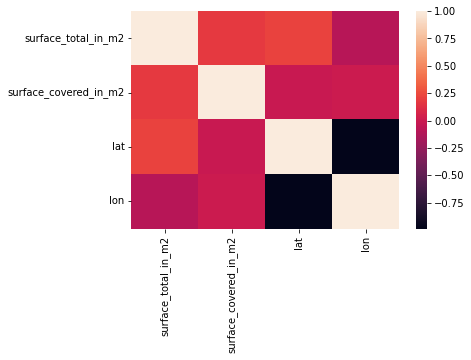

In [13]:
df_numeric = df.select_dtypes(include = "number")
df_numeric.drop(columns = ["price_aprox_usd"], inplace = True)
corr = df_numeric.corr(method = "pearson")
sns.heatmap(corr)

As everyone see the correlation coefficient between "surface_covered_in_m2" and "surface_total_in_m2" is pretty high we only need one of them so I will drop "surface_total_in_m2"

In [14]:
df.drop(columns = ["surface_total_in_m2"], inplace = True)
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
3,48822.82,100.0,19.279771,-99.234597,Tlalpan
12,94022.66,57.0,23.634501,-102.552788,Benito Juárez
15,66384.96,103.0,19.362690,-99.150565,Benito Juárez
21,70880.12,56.0,19.402413,-99.095391,Iztacalco
22,68228.99,80.0,19.357820,-99.149406,Benito Juárez


### Remove Outlier

In [15]:
low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
mask_area = df["surface_covered_in_m2"].between(low, high)
df = df[mask_area]
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
12,94022.66,57.0,23.634501,-102.552788,Benito Juárez
21,70880.12,56.0,19.402413,-99.095391,Iztacalco
22,68228.99,80.0,19.357820,-99.149406,Benito Juárez
23,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
27,94140.20,50.0,19.354219,-99.126244,Coyoacán


# 3. Split Data

### Split Data

In [16]:
target = "price_aprox_usd"
X = df.drop(columns = [target])
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1101, 4)
y shape: (1101,)


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, 
                                                 random_state = 42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_val.shape)
print("y_test shape:", y_val.shape)

X_train shape: (880, 4)
y_train shape: (880,)
X_test shape: (221, 4)
y_test shape: (221,)


In [18]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_pred_baseline, y_train)
print("Baseline MAE:", round(mae_baseline, 2))

Baseline MAE: 17146.18


# 4. Build Model

### 3.1 Linear Regression

In [19]:
model_lr = make_pipeline(OneHotEncoder(), SimpleImputer(), LinearRegression())
# Fit model
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['borough'])),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [20]:
y_pred = model_lr.predict(X_val)
print("Training MAE:", mean_absolute_error(y_val, y_pred))

Training MAE: 15650.600935173681


In [21]:
X_test = pd.read_csv("/content/drive/MyDrive/mexico-house/mexico-city-test-features.csv", index_col = 0)
y_pred_test = pd.Series(model_lr.predict(X_test))
y_pred_test.head()

0    55179.029052
1    54084.676662
2    29985.382407
3    55095.737859
4    67672.108888
dtype: float64

Communicate Results

In [29]:
intercept = model_lr.named_steps["linearregression"].intercept_
coefficients = model_lr.named_steps["linearregression"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 17
[   337.66105386 -25985.07377873 -34275.67725304   4952.8141056
  13434.81381221]


In [31]:
feature_names = model_lr.named_steps["onehotencoder"].get_feature_names_out()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 17
['surface_covered_in_m2', 'lat', 'lon', 'borough_1', 'borough_2']


In [32]:
feat_imp = pd.Series(coefficients, index = feature_names)
feat_imp.head()

surface_covered_in_m2      337.661054
lat                     -25985.073779
lon                     -34275.677253
borough_1                 4952.814106
borough_2                13434.813812
dtype: float64

In [33]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = -2865001.11
+ (337.66 * surface_covered_in_m2)
+ (-25985.07 * lat)
+ (-34275.68 * lon)
+ (4952.81 * borough_1)
+ (13434.81 * borough_2)
+ (3615.74 * borough_3)
+ (-3327.49 * borough_4)
+ (3208.87 * borough_5)
+ (675.15 * borough_6)
+ (1951.57 * borough_7)
+ (7232.75 * borough_8)
+ (-14570.9 * borough_9)
+ (-12375.02 * borough_10)
+ (6107.89 * borough_11)
+ (7302.01 * borough_12)
+ (-1464.3 * borough_13)
+ (-16743.89 * borough_14)


Text(0.5, 1.0, 'Feature Importance for Apartment Price')

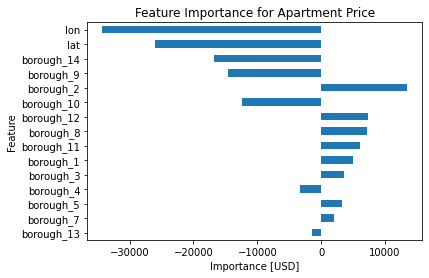

In [34]:
feat_imp.sort_values(key=abs).tail(15).plot(kind = "barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price")

### 3.2 Ridge

In [35]:
model_ridge = make_pipeline(OneHotEncoder(), SimpleImputer(), Ridge())
model_ridge.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['borough'])),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [36]:
y_pred = model_ridge.predict(X_val)
print("Training MAE:", mean_absolute_error(y_val, y_pred))

Training MAE: 15712.621701521428


In [37]:
y_pred_test = pd.Series(model_ridge.predict(X_test))
y_pred_test.head()

0    54764.970002
1    52529.193734
2    31854.424129
3    54719.410221
4    68035.184270
dtype: float64

Communicate Results

In [46]:
coefficients = model_ridge.named_steps["ridge"].coef_
features = model_ridge.named_steps["onehotencoder"].get_feature_names_out()
feat_imp = pd.Series(coefficients, index = features)
feat_imp

surface_covered_in_m2      345.829925
lat                      -6954.319296
lon                     -10585.223783
borough_1                 3206.454118
borough_2                13269.653039
borough_3                 4954.898879
borough_4                -5182.775767
borough_5                 3484.798652
borough_6                 -483.423916
borough_7                 1537.108371
borough_8                 9025.360476
borough_9               -14815.164985
borough_10              -13412.623539
borough_11                4871.091603
borough_12                7399.403262
borough_13               -3883.261537
borough_14               -9971.518655
dtype: float64

In [47]:
feat_imp = pd.Series(coefficients, index = feature_names)
feat_imp.head()

surface_covered_in_m2      345.829925
lat                      -6954.319296
lon                     -10585.223783
borough_1                 3206.454118
borough_2                13269.653039
dtype: float64

Text(0.5, 1.0, 'Feature Importance for Apartment Price')

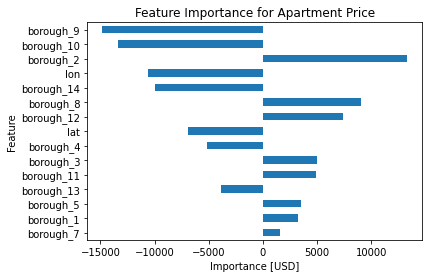

In [48]:
feat_imp.sort_values(key=abs).tail(15).plot(kind = "barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price")